# Evaluation of the borrower's creditworthiness

## Data upload

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from pymystem3 import Mystem
m = Mystem()
import functools
from string import punctuation
from nltk.corpus import stopwords

df = pd.read_csv('/datasets/data.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     19351 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      19351 non-null  float64
 11  purpose           21525 non-null  object 
dtypes: float64(2), int64(5), object(5)
memory usage: 2.0+ MB


In [2]:
df.head(5)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
0,1,-8437.673028,42,высшее,0,женат / замужем,0,F,сотрудник,0,253875.639453,покупка жилья
1,1,-4024.803754,36,среднее,1,женат / замужем,0,F,сотрудник,0,112080.014102,приобретение автомобиля
2,0,-5623.422610,33,Среднее,1,женат / замужем,0,M,сотрудник,0,145885.952297,покупка жилья
3,3,-4124.747207,32,среднее,1,женат / замужем,0,M,сотрудник,0,267628.550329,дополнительное образование
4,0,340266.072047,53,среднее,1,гражданский брак,1,F,пенсионер,0,158616.077870,сыграть свадьбу


**Conclusion**

Already on the first five lines it is clear that the same values are case-sensitive ("Average" and "average" in the education column). Let's take this into account when preprocessing the data.
There are negative values in the "days_employed" column. We have no information about the format of the data provided, perhaps it is the difference between the start date and the date serving as a reference point. We will ignore them for further analysis.
The columns days_employed, total_income have zero values. Among the numeric data, there is both the float type and the int type.

## Data preprocessing

### Missed values

In [3]:
df[df['days_employed'].isna()==True]
#let's look at the lines in which there are missing values

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose
12,0,NaN,65,среднее,1,гражданский брак,1,M,пенсионер,0,NaN,сыграть свадьбу
26,0,NaN,41,среднее,1,женат / замужем,0,M,госслужащий,0,NaN,образование
29,0,NaN,63,среднее,1,Не женат / не замужем,4,F,пенсионер,0,NaN,строительство жилой недвижимости
41,0,NaN,50,среднее,1,женат / замужем,0,F,госслужащий,0,NaN,сделка с подержанным автомобилем
55,0,NaN,54,среднее,1,гражданский брак,1,F,пенсионер,1,NaN,сыграть свадьбу
...,...,...,...,...,...,...,...,...,...,...,...,...
21489,2,NaN,47,Среднее,1,женат / замужем,0,M,компаньон,0,NaN,сделка с автомобилем
21495,1,NaN,50,среднее,1,гражданский брак,1,F,сотрудник,0,NaN,свадьба
21497,0,NaN,48,ВЫСШЕЕ,0,женат / замужем,0,F,компаньон,0,NaN,строительство недвижимости
21502,1,NaN,42,среднее,1,женат / замужем,0,F,сотрудник,0,NaN,строительство жилой недвижимости


The number of rows with missing values (more than 2 thousand) seems too large. In the formulation of the research task, the relationship of indicators with the number of days of employment does not appear anywhere - let's fill in the missing values in the days_employed column with zeros, and in the total_income column with the median value, as more resistant to outliers.

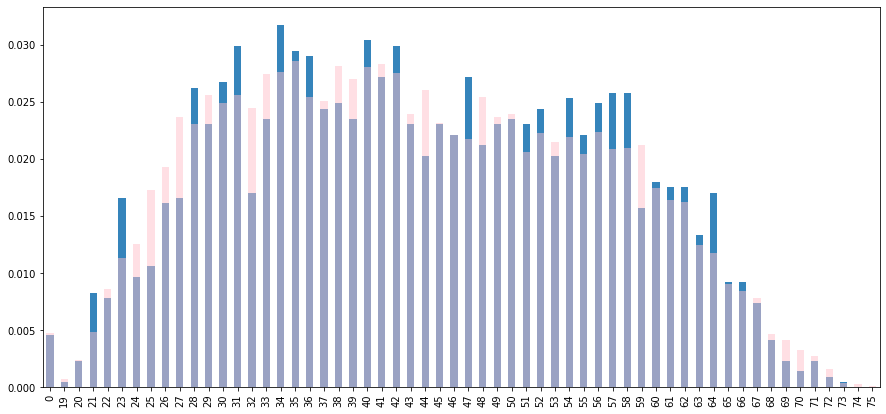

<AxesSubplot:>

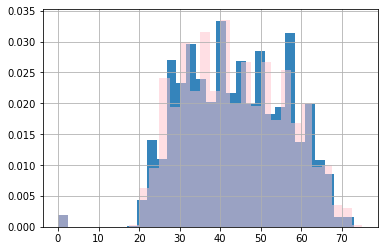

In [4]:
fig = plt.figure(figsize=(15,7))

df[df['days_employed'].isna()]['dob_years'].value_counts(normalize=True).sort_index().plot(kind='bar', alpha=0.9)
df[df['days_employed'].notna()]['dob_years'].value_counts(normalize=True).sort_index().plot(kind='bar',color='pink', alpha=0.5)

plt.show()

df[df['days_employed'].isna()]['dob_years'].hist(density=True, bins=30, alpha=0.9)
df[df['days_employed'].notna()]['dob_years'].hist(density=True, bins=30, alpha=0.5, color='pink')

In [5]:
df_test=df[(df['days_employed'].isna()==False)&(df['days_employed'].isna()==False)]
df_test.isnull().sum()
#check that the missing values match for two columns

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

In [6]:
income_missing_data=df[df['total_income'].isna()==True]
income_missing_data['income_type'].value_counts(normalize=True)
#let's look at the distribution of passes in the total_income column by employment categories

сотрудник          0.508280
компаньон          0.233671
пенсионер          0.189972
госслужащий        0.067617
предприниматель    0.000460
Name: income_type, dtype: float64

In [7]:
income_without_missing_data=df[df['total_income'].isna()==False]
income_without_missing_data['income_type'].value_counts(normalize=True)
#let's look at the distribution in the total_income column by employment categories 
#for those rows where there are no missing values

сотрудник          0.517493
компаньон          0.236525
пенсионер          0.177924
госслужащий        0.067800
безработный        0.000103
студент            0.000052
предприниматель    0.000052
в декрете          0.000052
Name: income_type, dtype: float64

In [8]:
df['days_employed'] = df['days_employed'].fillna(df.groupby(['dob_years'])['days_employed'].transform('mean'))
#replace the gaps in the days_employed column with average values depending on the age of the borrower,
#making the assumption that work experience depends on age

df['total_income'] = df['total_income'].fillna(df.groupby(['income_type'])['total_income'].transform('median'))
#replace the gaps in the total_income column with the median values for each category

In [9]:
df.isnull().sum()
#check that there are no missing values left

children            0
days_employed       0
dob_years           0
education           0
education_id        0
family_status       0
family_status_id    0
gender              0
income_type         0
debt                0
total_income        0
purpose             0
dtype: int64

**Conclusion**

The number of missing values in the original dataset is the same for the days_employed and total_income columns. There is not a single line where the value in the days_employed column was omitted, and not omitted in the total_income column, and vice versa. Probably, if they forget to fill in the value for one field in the questionnaire, a pass for another is automatically substituted. 	

### Changing data types

In [10]:
for column in ['children', 'total_income']:
    df[column] = df[column].astype('int')
#replacing data in columns with the float type with an integer

In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21525 entries, 0 to 21524
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   children          21525 non-null  int64  
 1   days_employed     21525 non-null  float64
 2   dob_years         21525 non-null  int64  
 3   education         21525 non-null  object 
 4   education_id      21525 non-null  int64  
 5   family_status     21525 non-null  object 
 6   family_status_id  21525 non-null  int64  
 7   gender            21525 non-null  object 
 8   income_type       21525 non-null  object 
 9   debt              21525 non-null  int64  
 10  total_income      21525 non-null  int64  
 11  purpose           21525 non-null  object 
dtypes: float64(1), int64(6), object(5)
memory usage: 2.0+ MB


**Conclusion**

To increase the accuracy of the data, it is recommended to replace the real data type with an integer.

### Duplicate values processing

In [12]:
for column in ['education', 'family_status', 'gender', 'income_type', 'purpose']:
    df[column] = df[column].str.lower()
#reduce all values in columns with the "object" type to lowercase
df.duplicated().sum()
#let's look at the number of duplicates in the updated dataframe

71

In [13]:
df=df.drop_duplicates().reset_index(drop=True)
#dropping duplicates

In [14]:
df.duplicated().sum()
#let's look at the number of duplicates in the updated dataframe

0

**Conclusion**

There were 71 fully duplicated lines in the original dataframe. It is unlikely that all the values for the 12 columns matched for so many people, so it was decided to delete these rows. There is probably some problem with collecting or uploading data.

### Lemmatization

In [15]:
@functools.lru_cache()
def get_lemmas(purpose):
    return m.lemmatize(purpose)

df['purpose_lemmas'] = df['purpose'].apply(get_lemmas)
df.sample(10)
#look at the result

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas
3007,0,-9746.372714,53,среднее,1,женат / замужем,0,f,компаньон,0,266487,на покупку автомобиля,"[на, , покупка, , автомобиль, \n]"
446,2,-5444.643865,36,высшее,0,женат / замужем,0,m,госслужащий,0,164190,профильное образование,"[профильный, , образование, \n]"
9239,0,346047.256129,64,среднее,1,не женат / не замужем,4,f,пенсионер,0,91821,на покупку подержанного автомобиля,"[на, , покупка, , подержать, , автомобиль, \n]"
1299,0,372199.240892,61,среднее,1,гражданский брак,1,f,пенсионер,0,80833,сыграть свадьбу,"[сыграть, , свадьба, \n]"
866,0,-7150.743101,42,среднее,1,гражданский брак,1,f,сотрудник,0,127908,покупка жилой недвижимости,"[покупка, , жилой, , недвижимость, \n]"
5483,0,-7748.198133,58,среднее,1,вдовец / вдова,2,f,сотрудник,0,86249,недвижимость,"[недвижимость, \n]"
19945,0,-1403.779132,66,среднее,1,женат / замужем,0,f,сотрудник,0,165996,образование,"[образование, \n]"
6825,1,-731.396794,0,высшее,0,в разводе,3,f,сотрудник,0,247540,покупка жилья,"[покупка, , жилье, \n]"
10211,1,-1661.074083,39,неоконченное высшее,2,женат / замужем,0,m,компаньон,0,97372,покупка жилья для сдачи,"[покупка, , жилье, , для, , сдача, \n]"
6508,0,-9838.162643,60,среднее,1,женат / замужем,0,f,сотрудник,0,126500,покупка жилья,"[покупка, , жилье, \n]"


For more accurate data analysis, the value of the purpose column was lemmatized - now the rows with indexes 20 and 24 ("car" and "cars") in the list of unique values after lemmatization will no longer be unique. During the categorization of data, it will now be possible to divide all borrowers into groups depending on the purpose of the loan.

### Other data preprocessing

In [16]:
df['children'].min()


-1

In [17]:
df['children']=df['children'].replace(-1,1)
#we replace the negative value "-1" with "1"

**Conclusion**

During further data analysis, a problem was discovered that was not identified at the initial stage of data preprocessing: negative values in the "children" column, probably related to incorrect filling out of the form on the website/in the database - an extra "-" was added before the digit.

### Data categorization

In [18]:
stop_words=stopwords.words("russian")
lemmas_cleaned=[]

for text in df['purpose_lemmas']:
    text = [word for word in text if word not in stop_words]
    lemmas_cleaned.append(text)

df['purpose_lemmas_clean']=lemmas_cleaned
df.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_lemmas_clean
18755,1,382095.717952,56,среднее,1,вдовец / вдова,2,m,пенсионер,1,162376,операции со своей недвижимостью,"[операция, , со, , свой, , недвижимость, \n]","[операция, , , свой, , недвижимость, \n]"
15555,0,-4265.412485,41,среднее,1,гражданский брак,1,f,компаньон,0,222517,операции со своей недвижимостью,"[операция, , со, , свой, , недвижимость, \n]","[операция, , , свой, , недвижимость, \n]"
10754,1,-880.626027,26,среднее,1,женат / замужем,0,m,сотрудник,1,152121,получение образования,"[получение, , образование, \n]","[получение, , образование, \n]"
20241,1,-3028.027736,37,среднее,1,не женат / не замужем,4,m,компаньон,0,114251,профильное образование,"[профильный, , образование, \n]","[профильный, , образование, \n]"
18637,1,-1487.619217,30,среднее,1,женат / замужем,0,f,сотрудник,0,69490,дополнительное образование,"[дополнительный, , образование, \n]","[дополнительный, , образование, \n]"
20425,0,341983.343845,67,среднее,1,в разводе,3,f,пенсионер,0,57327,жилье,"[жилье, \n]","[жилье, \n]"
5136,1,-895.075157,22,высшее,0,гражданский брак,1,f,компаньон,0,135450,на проведение свадьбы,"[на, , проведение, , свадьба, \n]","[ , проведение, , свадьба, \n]"
12602,1,-3732.303070,38,высшее,0,женат / замужем,0,m,сотрудник,0,195502,операции с жильем,"[операция, , с, , жилье, \n]","[операция, , , жилье, \n]"
17673,0,-2008.875809,46,среднее,1,женат / замужем,0,f,сотрудник,0,159265,профильное образование,"[профильный, , образование, \n]","[профильный, , образование, \n]"
14778,1,-2419.250511,30,среднее,1,гражданский брак,1,f,компаньон,0,229519,на покупку своего автомобиля,"[на, , покупка, , свой, , автомобиль, \n]","[ , покупка, , свой, , автомобиль, \n]"


In [19]:
df['purpose_lemmas_clean']=lemmas_cleaned
#we clean the "purpose_lemmas" column from stop words and save everything to a new one
#the "purpose_lemmas_clean" column

lemmas_cleaned_final=[]
for text in df['purpose_lemmas_clean']:
    text = ''.join(c for c in text if c not in punctuation).strip()
    lemmas_cleaned_final.append(text)
    
df['purpose_lemmas_clean']=lemmas_cleaned_final
#removing punctuation marks

df.sample(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_lemmas_clean
1298,0,-656.620416,42,среднее,1,гражданский брак,1,f,госслужащий,0,172907,на проведение свадьбы,"[на, , проведение, , свадьба, \n]",проведение свадьба
20319,0,-336.963372,47,среднее,1,гражданский брак,1,m,сотрудник,0,61724,свадьба,"[свадьба, \n]",свадьба
2688,0,-2263.846551,46,высшее,0,женат / замужем,0,m,сотрудник,0,567440,жилье,"[жилье, \n]",жилье
13991,1,-954.029054,37,высшее,0,гражданский брак,1,f,компаньон,0,137823,на проведение свадьбы,"[на, , проведение, , свадьба, \n]",проведение свадьба
19352,0,-2963.076314,25,среднее,1,женат / замужем,0,m,сотрудник,0,201598,покупка жилья для семьи,"[покупка, , жилье, , для, , семья, \n]",покупка жилье семья
7278,0,-1333.025172,27,среднее,1,не женат / не замужем,4,m,сотрудник,0,498767,покупка жилья для сдачи,"[покупка, , жилье, , для, , сдача, \n]",покупка жилье сдача
4030,0,-200.806514,28,неоконченное высшее,2,не женат / не замужем,4,m,компаньон,1,106950,покупка недвижимости,"[покупка, , недвижимость, \n]",покупка недвижимость
1383,0,353802.811675,37,среднее,1,вдовец / вдова,2,f,пенсионер,0,216452,строительство недвижимости,"[строительство, , недвижимость, \n]",строительство недвижимость
9510,0,-154.932211,22,неоконченное высшее,2,не женат / не замужем,4,f,компаньон,0,84849,покупка жилой недвижимости,"[покупка, , жилой, , недвижимость, \n]",покупка жилой недвижимость
17713,0,-2916.627480,43,среднее,1,гражданский брак,1,f,сотрудник,0,174931,на покупку подержанного автомобиля,"[на, , покупка, , подержать, , автомобиль, \n]",покупка подержать автомобиль


In [20]:
df['purpose_lemmas_clean'].value_counts()

автомобиль                                972
свадьба                                   791
проведение свадьба                        768
сыграть свадьба                           765
операция  недвижимость                    675
покупка коммерческий недвижимость         661
операция  жилье                           652
покупка жилье  сдача                      651
операция  коммерческий недвижимость       650
жилье                                     646
покупка жилье                             646
покупка жилье  семья                      638
строительство собственный недвижимость    635
недвижимость                              633
операция  свой недвижимость               627
строительство жилой недвижимость          624
покупка недвижимость                      621
покупка свой жилье                        620
строительство недвижимость                619
ремонт жилье                              607
покупка жилой недвижимость                606
покупка свой автомобиль           

In [21]:
def define_purpose_category (lem_group):
    if ('недвижимость' in lem_group) | ('жилье' in lem_group):
        return 'real estate'
    elif 'автомобиль' in lem_group:
        return 'vehicle'
    elif 'образование' in lem_group:
        return 'education'
    elif 'свадьба' in lem_group:
        return 'marriage'    
    else:
        return 'other'

df['purpose_category'] = df['purpose_lemmas'].apply(define_purpose_category)
#apply the function of categorizing the reasons for the purposes of the loan 
#to the "purpose_lemmas" column and write the result of the function in a new
#the "purpose_category" column  

In [22]:
df.groupby('purpose_category')['children'].sum()
#let's see how the number of children is distributed for each reason to take out a loan

purpose_category
education      2222
marriage       1257
real estate    5877
vehicle        2322
Name: children, dtype: int64

So far, everything seems logical: people who are planning a wedding should have fewer children than those who have not started a family life. Probably, families with children are more likely to upgrade and buy a car or improve living conditions, and parents don't have much free time to get additional education. The define_purpose_category function has not assigned the value 'other' to any row, therefore, there are only 4 generalized reasons for obtaining a loan in the data under study.

In [23]:
df_total_income = pd.DataFrame(df['total_income'],columns=['total_income']).astype('int')

In [24]:
#we will divide debtors into 4 groups depending on the level of income
labels=['poor','income below or equal to average','income above average','rich']
df['income_category']=pd.qcut(df['total_income'],4, labels=labels)
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_lemmas_clean,purpose_category,income_category
0,1,-8437.673028,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,rich
1,1,-4024.803754,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,"[приобретение, , автомобиль, \n]",приобретение автомобиль,vehicle,income below or equal to average
2,0,-5623.422610,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,income above average
3,3,-4124.747207,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,"[дополнительный, , образование, \n]",дополнительный образование,education,rich
4,0,340266.072047,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,"[сыграть, , свадьба, \n]",сыграть свадьба,marriage,income above average
5,0,-926.185831,27,высшее,0,гражданский брак,1,m,компаньон,0,255763,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,rich
6,0,-2879.202052,43,высшее,0,женат / замужем,0,f,компаньон,0,240525,операции с жильем,"[операция, , с, , жилье, \n]",операция жилье,real estate,rich
7,0,-152.779569,50,среднее,1,женат / замужем,0,m,сотрудник,0,135823,образование,"[образование, \n]",образование,education,income below or equal to average
8,2,-6929.865299,35,высшее,0,гражданский брак,1,f,сотрудник,0,95856,на проведение свадьбы,"[на, , проведение, , свадьба, \n]",проведение свадьба,marriage,poor
9,0,-2188.756445,41,среднее,1,женат / замужем,0,m,сотрудник,0,144425,покупка жилья для семьи,"[покупка, , жилье, , для, , семья, \n]",покупка жилье семья,real estate,income above average


In [25]:
df['children'].describe()
#let's define the interval boundaries for the cut function by the children column

count    21454.000000
mean         0.544327
std          1.381726
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max         20.000000
Name: children, dtype: float64

In [26]:
bins=[-1,0,2,20]
labels=['no children', 'have children', 'many children']
df['children_category'] = pd.cut(df['children'], bins, labels=labels)
df.head(10)

,children,days_employed,dob_years,education,education_id,family_status,family_status_id,gender,income_type,debt,total_income,purpose,purpose_lemmas,purpose_lemmas_clean,purpose_category,income_category,children_category
0,1,-8437.673028,42,высшее,0,женат / замужем,0,f,сотрудник,0,253875,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,rich,have children
1,1,-4024.803754,36,среднее,1,женат / замужем,0,f,сотрудник,0,112080,приобретение автомобиля,"[приобретение, , автомобиль, \n]",приобретение автомобиль,vehicle,income below or equal to average,have children
2,0,-5623.422610,33,среднее,1,женат / замужем,0,m,сотрудник,0,145885,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,income above average,no children
3,3,-4124.747207,32,среднее,1,женат / замужем,0,m,сотрудник,0,267628,дополнительное образование,"[дополнительный, , образование, \n]",дополнительный образование,education,rich,many children
4,0,340266.072047,53,среднее,1,гражданский брак,1,f,пенсионер,0,158616,сыграть свадьбу,"[сыграть, , свадьба, \n]",сыграть свадьба,marriage,income above average,no children
5,0,-926.185831,27,высшее,0,гражданский брак,1,m,компаньон,0,255763,покупка жилья,"[покупка, , жилье, \n]",покупка жилье,real estate,rich,no children
6,0,-2879.202052,43,высшее,0,женат / замужем,0,f,компаньон,0,240525,операции с жильем,"[операция, , с, , жилье, \n]",операция жилье,real estate,rich,no children
7,0,-152.779569,50,среднее,1,женат / замужем,0,m,сотрудник,0,135823,образование,"[образование, \n]",образование,education,income below or equal to average,no children
8,2,-6929.865299,35,высшее,0,гражданский брак,1,f,сотрудник,0,95856,на проведение свадьбы,"[на, , проведение, , свадьба, \n]",проведение свадьба,marriage,poor,have children
9,0,-2188.756445,41,среднее,1,женат / замужем,0,m,сотрудник,0,144425,покупка жилья для семьи,"[покупка, , жилье, , для, , семья, \n]",покупка жилье семья,real estate,income above average,no children


**Conclusion**

The generalized reasons for taking out a loan were real estate transactions, buying a car, education or, with a noticeable lag, a wedding. To simplify the work with the data, all borrowers were also categorized into 4 groups depending on the income level: upper and lower 25%, 25%-50% and 50%-75%. Depending on the number of children in the debtor's family, the debtors were categorized into large families (from 3 children and more, according to the legislation of the Russian Federation), childless, and just those who have children.

## Responding on study questions

***- Is there a relationship between having children and repayment of the loan on time?***

In [27]:
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(df.groupby('children_category').agg(debtors_share=('debt','mean')))       

,debtors_share
children_category,
no children,7.54%
have children,9.25%
many children,8.55%


**Conclusion**

If there are children in the family, the probability of delinquency of the loan increases.

***- Is there a relationship between marital status and repayment of the loan on time?***

In [28]:
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(df.groupby('family_status').agg(debtors_share=('debt','mean')))
    
# в разводе - divorced
# вдовец / вдова - widower / widow
# гражданский брак - civil marriage
# женат / замужем - married
# не женат / не замужем - unmarried    

,debtors_share
family_status,
в разводе,7.11%
вдовец / вдова,6.57%
гражданский брак,9.35%
женат / замужем,7.55%
не женат / не замужем,9.75%


**Conclusion**

The most risky group of clients are single people who have never been married.

***- Is there a relationship between the level of income and repayment of the loan on time?***

In [29]:
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(df.groupby('income_category').agg(debtors_share=('debt','mean')))

,debtors_share
income_category,
poor,7.96%
income below or equal to average,8.82%
income above average,8.54%
rich,7.14%


**Conclusion**

People with incomes closer to the average represent the most risky group.

 ***How do different loan goals affect its repayment on time?***

In [30]:
with pd.option_context('display.float_format', '{:.2%}'.format):
    display(df.groupby('purpose_category').agg(debtors_share=('debt','mean')))

,debtors_share
purpose_category,
education,9.22%
marriage,8.00%
real estate,7.23%
vehicle,9.36%


**Conclusion**

If a loan is taken for the purchase of a car or education, the probability of delaying it increases. It may be worth looking at this category in more detail and breaking it down into subcategories. Loans taken on real estate are given on time most often.

## General conclusion

Based on a preliminary analysis of the data, it can be concluded that the marital status and the number of children of the client affect the fact of repayment of the loan on time: the risk of having debt increases for single people, as well as for families with children. This should be taken into account in the further development of the credit scoring model.